In [1]:
import os
from okcupid_stackoverflow.src.tf_idf.tf_idf import run_fit_tf_idf
from okcupid_stackoverflow.utils.git_utils import get_git_root

In [2]:
git_root_loc = get_git_root(os.getcwd())

/Users/Akos/Desktop/okcupid/venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Model Performance metrics:
------------------------------
Log Loss: 0.4455
Accuracy: 0.7896
Precision: 0.7904
Recall: 0.7896
F1 Score: 0.7896

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.81      0.77      0.79     10071
           0       0.78      0.81      0.79      9929

    accuracy                           0.79     20000
   macro avg       0.79      0.79      0.79     20000
weighted avg       0.79      0.79      0.79     20000


Prediction Confusion Matrix:
------------------------------
          Predicted:      
                   1     0
Actual: 1       7731  2340
        0       1867  8062


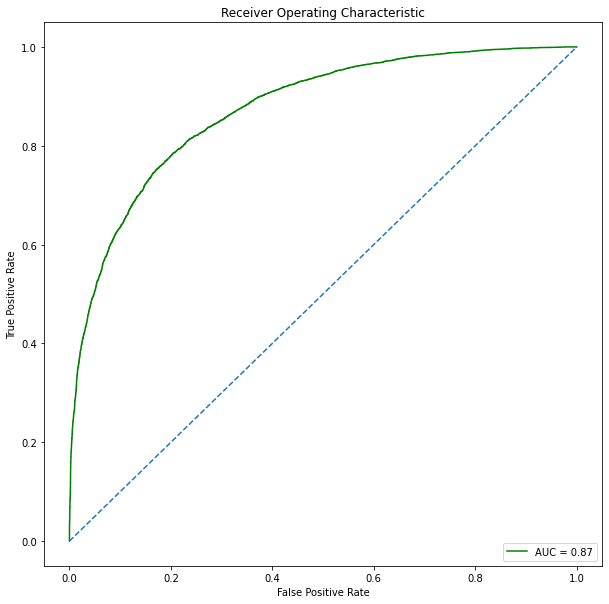

In [3]:
run_name = "akos_testing_pipeline_metadata"
use_metadata=True
run_fit_tf_idf(git_root_loc, run_id=run_name, save_external=True, use_metadata=use_metadata)

/Users/Akos/Desktop/okcupid/venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Model Performance metrics:
------------------------------
Log Loss: 0.5909
Accuracy: 0.7206
Precision: 0.7258
Recall: 0.7206
F1 Score: 0.7188

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.69      0.80      0.74     10071
           0       0.76      0.64      0.69      9929

    accuracy                           0.72     20000
   macro avg       0.73      0.72      0.72     20000
weighted avg       0.73      0.72      0.72     20000


Prediction Confusion Matrix:
------------------------------
          Predicted:      
                   1     0
Actual: 1       8051  2020
        0       3567  6362


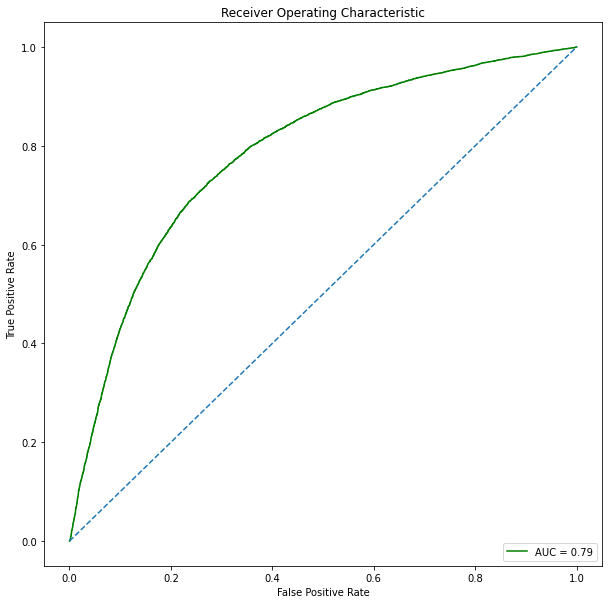

In [4]:
run_name = "akos_testing_pipeline_no_metadata"
use_metadata=False
run_fit_tf_idf(git_root_loc, run_id=run_name, save_external=True, use_metadata=use_metadata)